In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [3]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\Ajay\Desktop\Inno_Projects\Social Media Fake Account Detection\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 176 files [00:01, 133.70 files/s]


In [2]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [3]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [4]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
2 folder and 0 images in output\test
0 folder and 6 images in output\test\Fake
0 folder and 4 images in output\test\Real
2 folder and 0 images in output\train
0 folder and 83 images in output\train\Fake
0 folder and 48 images in output\train\Real
2 folder and 0 images in output\val
0 folder and 22 images in output\val\Fake
0 folder and 13 images in output\val\Real


In [5]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (256, 256, 3)


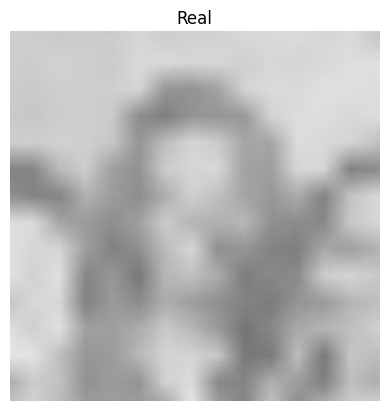

In [6]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Real')

Image Shape : (256, 256, 3)


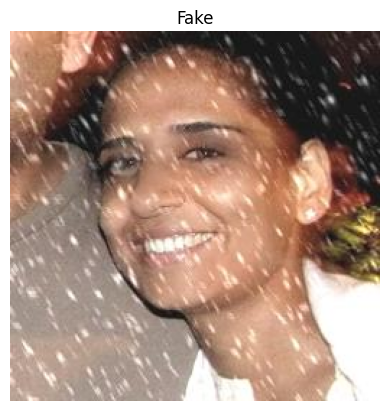

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Fake')

In [8]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [9]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 131 images belonging to 2 classes.
Found 35 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [10]:
train_data.class_indices

{'Fake': 0, 'Real': 1}

In [11]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [12]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (131,)
val_y.shape:  (35,)
test_y.shape:  (10,)


In [13]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [14]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(2)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                             

In [16]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=20, validation_data=valid_data)

Epoch 1/20


3/3 [==============================] - 20s 4s/step - loss: 0.7703 - accuracy: 0.6107 - val_loss: 0.7686 - val_accuracy: 0.4857
Epoch 2/20
3/3 [==============================] - 11s 3s/step - loss: 0.6980 - accuracy: 0.5725 - val_loss: 0.7988 - val_accuracy: 0.4857
Epoch 3/20
3/3 [==============================] - 10s 3s/step - loss: 0.7561 - accuracy: 0.5115 - val_loss: 0.8796 - val_accuracy: 0.4571
Epoch 4/20
3/3 [==============================] - 9s 2s/step - loss: 0.7903 - accuracy: 0.4427 - val_loss: 0.8143 - val_accuracy: 0.4857
Epoch 5/20
3/3 [==============================] - 9s 3s/step - loss: 0.7010 - accuracy: 0.5420 - val_loss: 0.6774 - val_accuracy: 0.6571
Epoch 6/20
3/3 [==============================] - 9s 4s/step - loss: 0.6264 - accuracy: 0.6870 - val_loss: 0.6649 - val_accuracy: 0.5429
Epoch 7/20
3/3 [==============================] - 10s 3s/step - loss: 0.7124 - accuracy: 0.6565 - val_loss: 0.6918 - val_accuracy: 0.6000
Epoch 8/20
3/3 [===================

In [18]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

In [19]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

1/1 [==============================] - 4s 4s/step
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        16
           1       0.92      0.63      0.75        19

    accuracy                           0.77        35
   macro avg       0.80      0.78      0.77        35
weighted avg       0.81      0.77      0.77        35



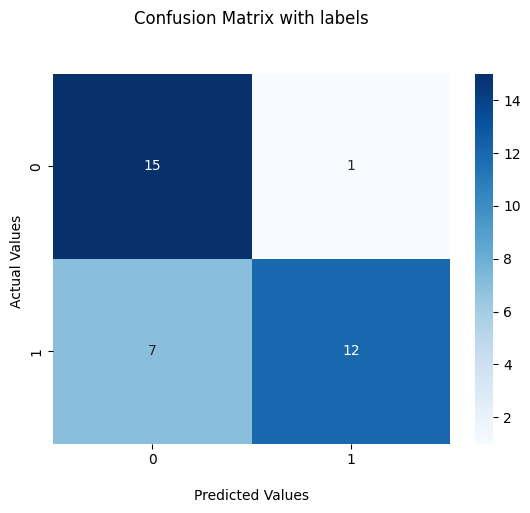

In [20]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [21]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

1/1 [==============================] - 1s 580ms/step
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.50      0.50      0.50         4

    accuracy                           0.60        10
   macro avg       0.58      0.58      0.58        10
weighted avg       0.60      0.60      0.60        10



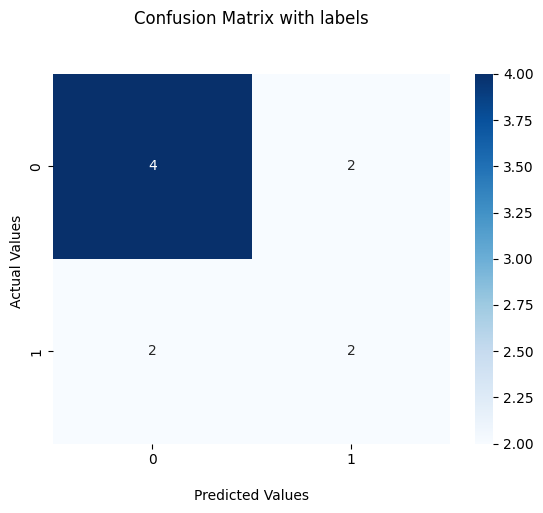

In [22]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [23]:
model.save('my_model.keras')

1/1 [==============================] - 2s 2s/step
Predicted Class: Real


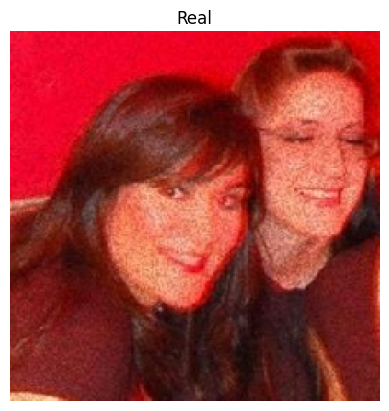

In [24]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\Ajay\Desktop\Social-Media-Fake-account-Detection-\Dataset\Real\real_934.jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Fake', 'Real']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()
